#### Business Analytics FHDW 2025
# Ein Beispiel zur logistischen Regression
## Interpretation des Modells zum Profiling von Bankkunden

Wir betrachten noch einmal den Datensatz *UniversalBank.csv*. Dieses Mal wollen wir weitere Prädiktoren berücksichtigen und die Ergebnisse in Richtung *Profiling* interpretieren.

Den Datensatz bereiten wir uns dazu etwas auf.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt

from dmba import classificationSummary, gainsChart, liftChart

bank_df = pd.read_csv('./Daten/UniversalBank.csv')
# Die Daten der Variablen ID und PLZ entfernen wir (im Original/inplace):
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1,1.9,3,0,0,0,0,1,0
4996,30,4,15,4,0.4,1,85,0,0,0,1,0
4997,63,39,24,2,0.3,3,0,0,0,0,0,0
4998,65,40,49,3,0.5,2,0,0,0,0,1,0


Die Variable *Ausbildung* (*Education*) ist im Datensatz als Integer kodiert. Daraus machen wir kategorische Dummy-Variablen und fassen dabei die drei bisher möglichen Werte zu zweien zusammen, um Multikollinearität zu vermeiden.

In [2]:
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced'}
bank_df['Education'] = bank_df.Education.cat.rename_categories(new_categories)
bank_df

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
0,25,1,49,4,1.6,Undergrad,0,0,1,0,0,0
1,45,19,34,3,1.5,Undergrad,0,0,1,0,0,0
2,39,15,11,1,1.0,Undergrad,0,0,0,0,0,0
3,35,9,100,1,2.7,Graduate,0,0,0,0,0,0
4,35,8,45,4,1.0,Graduate,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1,1.9,Advanced,0,0,0,0,1,0
4996,30,4,15,4,0.4,Undergrad,85,0,0,0,1,0
4997,63,39,24,2,0.3,Advanced,0,0,0,0,0,0
4998,65,40,49,3,0.5,Graduate,0,0,0,0,1,0


In [3]:
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)
bank_df

,Age,Experience,Income,Family,CCAvg,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard,Education_Graduate,Education_Advanced
0,25,1,49,4,1.6,0,0,1,0,0,0,False,False
1,45,19,34,3,1.5,0,0,1,0,0,0,False,False
2,39,15,11,1,1.0,0,0,0,0,0,0,False,False
3,35,9,100,1,2.7,0,0,0,0,0,0,True,False
4,35,8,45,4,1.0,0,0,0,0,0,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1,1.9,0,0,0,0,1,0,False,True
4996,30,4,15,4,0.4,85,0,0,0,1,0,False,False
4997,63,39,24,2,0.3,0,0,0,0,0,0,False,True
4998,65,40,49,3,0.5,0,0,0,0,1,0,True,False


*CCAvg* sind die durchschnittlichen Ausgaben über Kreditkarte pro Monat, *SecuritiesAccount* zeigt an, ob ein Wertpapierdepot bei der Bank besteht, *CDAccount*, ob ein Bankeinlagenkonto (certificate of deposit) besteht, *Online* bezieht sich auf die Nutzung von Internet Banking.

Auf dieser Basis können wir nun den Datensatz aufteilen und die logistische Regression durchführen. Wir wollen alle Variablen außer (natürlich) der Zielkategorie als Prädiktoren verwenden.

Ohne Vertiefung an dieser Stelle zu den gegebenen Parametern der Regression: `penalty` und `C` dienen der *Regularisierung* gegen *overfitting*. Das Modell bekommt hier Funktionen und Werte vorgegeben, mit denen Ausreißer, Verzerrungen oder zu starke Eigenarten, von denen wir annehmen, dass sie spezifisch für die Trainingsdaten sind, "bestraft" und damit geglättet werden. Die Klasse bietet außerdem unterschiedliche Optimierungsalgorithmen an, die je nach Umfang und Eigenschaften der Datensätze mit `solver` ausgewählt werden können.

In [4]:
y = bank_df['PersonalLoan']
X = bank_df.drop(columns=['PersonalLoan'])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

log_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
log_reg.fit(train_X, train_y)

print('intercept ', log_reg.intercept_[0])
coefficients = pd.DataFrame({'coeff': log_reg.coef_[0]}, index=X.columns)
print(coefficients.transpose())

intercept  -12.491957854260937
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.037738    0.039255  0.058843  0.612243  0.240486  0.001012   

       SecuritiesAccount  CDAccount    Online  CreditCard  Education_Graduate  \
coeff          -1.014505   3.649236 -0.678298   -0.958199            4.202129   

       Education_Advanced  
coeff            4.355743  


Um das theoretische Fundament nicht außen vor zu lassen, hier ausführlich das, was wir nun aufgestellt haben. Unser Vektor aus
zwölf Prädiktoren ist 

$X=(Age, Experience, Income, Family, CCAvg, Mortgage, SecuritiesAccount, CDAccount, Online, CreditCard, Education\_Graduate, Education\_Advanced)$ 

Mit den ermittelten Werten oben ergibt sich der 

$Logit(PersonalLoan=Yes|X) = -12.1052-0.0517 Age + 0.053 Experience + 0.0587 Income + 0.61 Family + 0.2404 CCAvg + 0.001 Mortgage - 1.0301 \underline{SecuritiesAccount} + 3.6482 \underline{CDAccount} - 0.6789 \underline{Online} - 0.9611 \underline{CreditCard} + 4.1987 \underline{Education\_Graduate} + 4.3588 \underline{Education\_Advanced}$

Die unterstrichenen Variablen sind binär, also *ja/1* oder *nein/0*.

Aus den einzelnen Werten können wir bereits Tendenzen für die Kundenprofile ablesen. Je nach Vorzeichen und Größe beeinflusst der jeweilige Wert die Klassifizierung eines Kunden und damit seine Wahrscheinlichkeit, ein Darlehen zu akzeptieren. Ein Einlagenkonto und höherer Bildungsabschluss z. B. sind verbunden mit einer höheren Wahrscheinlichkeit. Ein Wertpapierdepot, Online Banking und eine Kreditkarte vermindern die Bereitschaft für das Darlehen.

Interessant für die Profilbildung ist aber auch die Frage nach den konkreten, also quantifizierten Einflüssen der einzelnen Prädiktoren: Z. B. um welchen Wert ändert sich die Ziel-Wahrscheinlichkeit, wenn sich das Einkommen um eine Einheit erhöht? Das können wir direkt ablesen, wenn wir die *Odds* betrachten.

Das liegt darin begründet, dass sich das Verhältnis zwischen den $Odds$ für einen Wert $x_i$ und $x_i+1$ auf eine Konstante reduzieren lässt (alle $x_j$ mit $j\neq i$ bleiben unverändert):

$\frac{Odds(x_1,...,x_i+1,...,x_n)}{Odds(x_1,...,x_i,...,x_n)} = \frac{e^{\beta_0+\beta_1 x_1+...+\beta_i(x_i+1)+...+\beta_n x_n}}{e^{\beta_0+\beta_1 x_1+...+\beta_ix_i+...+\beta_n x_n}} = e^{\beta_i}$

Bei einer Berechnung des Verhältnisses auf Basis der Wahrscheinlichkeiten würde das $x_i$ bestehen bleiben, das Ergebnis bei Steigerung um eine Einheit also immer auch von der jeweiligen Größe der Prädiktorvariable abhängig bleiben. 

Im gegebenen Beispiel wird also jeder Geburtstag eines Kunden die Chance, dass er ein Darlehen in Anspruch nimmt, um den Faktor

In [5]:
np.exp(coefficients['coeff']['Age'])

0.9629650763668736

senken (wenn alle anderen Prädiktoren unverändert bleiben). Im Falle eines binären Prädiktors ist die Chance, dass z. B. eine Kundin mit einem fortgeschrittenen Bildungsabschluss ein Darlehen in Anspruch nimmt, um 

In [6]:
np.exp(coefficients['coeff']['Education_Advanced'])

77.9246861432486

höher gegenüber einem Kunden ohne einen solchen Abschluss.

*Was sind eigentlich solche theoretischen Betrachtungen in der Praxis wert? Wieso sind die dort heute relevant?*

## Performance der Klassifikation

Betrachten wir noch die Qualität der prognostizierten Klassifikationen von Bankkunden. Für den Testdatensatz ermitteln wir dazu die Klassifikationen (*default cutoff* von 0.5) und deren Wahrscheinlichkeiten, bzw. *propensities*, Neigungen. Dazu können wir uns die Konfusionsmatrix anzeigen lassen.

In [7]:
log_reg_predictions = log_reg.predict(valid_X)
log_reg_probabilities = log_reg.predict_proba(valid_X)

classificationSummary(valid_y, log_reg_predictions)

Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


Zwei weitere hilfreiche Diagramme sind die kumulierten Zuwächse (*cumulative gains chart*) und die relativen Steigerungen (*lift chart*). Zur Vorbereitung erstellen wir eine Liste mit den Wahrscheinlichkeiten aller Datenpunkte aus dem Validierungsdatensatz. Diese sortieren wir absteigend nach den Erfolgswahrscheinlichkeiten von Ereignis 1 bzw. hier der Annahme eines Darlehens. Die "potentiell erfolgreichsten" Datensätze stehen also oben in der Liste. 

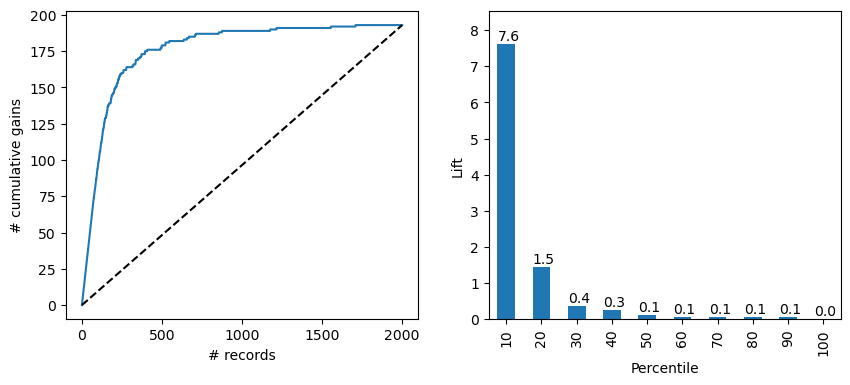

In [8]:
log_reg_result = pd.DataFrame({'tatsächlich': valid_y,
                               'p(0)': [p[0] for p in log_reg_probabilities],
                               'p(1)': [p[1] for p in log_reg_probabilities],
                               'vorhergesagt': log_reg_predictions})
result_sorted = log_reg_result.sort_values(by=['p(1)'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
gainsChart(result_sorted.tatsächlich, ax= axes[0])
liftChart(result_sorted.tatsächlich, title=False, ax= axes[1])
plt.show()

Das Gains-Diagramm zeigt uns damit die Steigerungskurve von für die Prognose eingesetzten, auf die obige Weise geordneten Datensätzen (x-Achse) gegenüber einer zufälligen Auswahl von Datensätzen (gestrichelte Linie). Praktisch für das Beispiel interpretiert: Die Kunden, die laut unserer logistischen Regression die höchsten Wahrscheinlichkeiten aufweisen, sind am lohnendsten für ein Darlehensangebot und sollten zuerst angesprochen werden. Im Lift-Diagramm sehen wir entsprechend, dass die obersten 10% dieser sortierten Liste fast 8-fach erhöhte Erfolgsaussichten gegenüber einer zufälligen 10%-Auswahl besitzen. 

## Aufgabe

Eine Personalberatung untersucht die Einflüsse der Erfahrung und Ausbildung von Systemadmins auf deren Fähigkeit, bestimmte Aufgaben in begrenzter Zeit zu lösen. Die Daten von 75 Admins finden sich in `SystemAdministrators.csv`: Die Variable *Experience* zeigt die Vollzeitbeschäftigung als Admin in Monaten, *Training* erworbene, fachlich relevante Credit Points, die Zielvariable *Completed task* zeigt, ob die Aufgaben in der verfügbaren Zeit gelöst wurden.

1. Generieren Sie einen Scatterplot, der (z. B. farblich) illustriert, wer die Aufgaben gelöst hat und wer nicht. Welcher Prädiktor ist potentiell verwendbar für eine Vorhersage der erfolgreichen Aufgabenlösung?

2. Implementieren Sie ein logistisches Regressionsmodell mit beiden Prädiktoren, das den gesamten Datensatz für das Training nutzt. Was ist der Prozentsatz der erfolgreichen Admins, die fälschlich als gescheitert eingeordnet werden, wenn Sie die Trainingsdaten auch für die Vorhersage verwenden?

3. Sollten Sie den *cutoff* höher oder niedriger setzen, um den Prozentsatz aus 2 zu senken?

4. Wie viele Monate Erfahrung muss ein Admin mit 4 Credits besitzen, damit die Erfolgswahrscheinlichkeit für die zeitige Aufgabenlösung 0.5 erreicht?